### Dependências

Foi escolhida a biblioteca yfinance para análise de dados financeiros, visto a variedade de aplicações em séries temporais.

In [36]:
pip install yfinance --upgrade --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Imports

In [37]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from tensorflow.keras import layers

## Definindo Dataset

In [38]:
ticker = 'AAPL' # apple
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')
data = data['Close'] # dados de fechamento
data.head()

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02    75.087502
2020-01-03    74.357498
2020-01-06    74.949997
2020-01-07    74.597504
2020-01-08    75.797501
Name: Close, dtype: float64

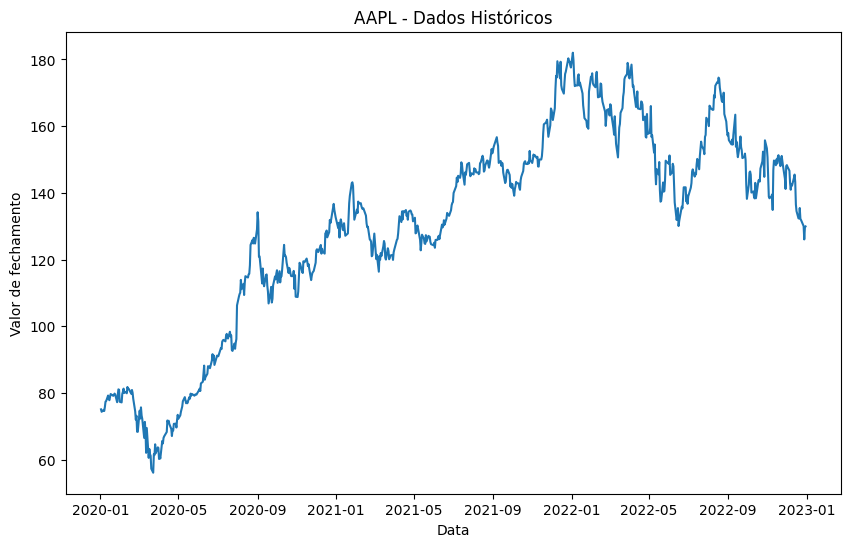

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title(f'{ticker} - Dados Históricos')
plt.xlabel('Data')
plt.ylabel('Valor de fechamento')
plt.show()

## Naive Bayes

In [40]:
def naive_forecast(data):
    '''Implementa uma previsão ingênua onde a previsão é simplesmente o valor anterior. 
        Calcula e imprime o RMSE para a avaliação do modelo ingênuo.'''
    forecast = data.shift(1)
    rmse = np.sqrt(mean_squared_error(data[1:], forecast[1:]))
    return forecast, rmse

Naive RMSE: 2.7924720976815447


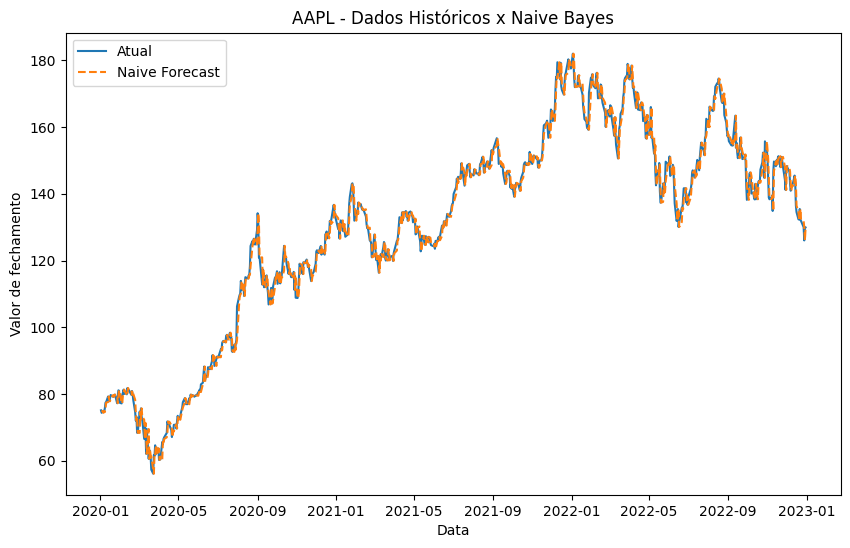

In [41]:
forecast, rmse = naive_forecast(data)
print(f'Naive RMSE: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(data, label='Atual')
plt.plot(forecast, label='Naive Forecast', linestyle='--')
plt.title(f'{ticker} - Dados Históricos x Naive Bayes')
plt.xlabel('Data')
plt.ylabel('Valor de fechamento')
plt.legend()
plt.show()

## Rede Neural Densa

In [42]:
sequence_length = 10 # 10 ultimos dias de preços para realizar a previsão

# divisão 80/20, mantendo a ordem cronologica
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
val_scaled = scaler.transform(val_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled, sequence_length)
X_val, y_val = create_dataset(val_scaled, sequence_length)
X_test, y_test = create_dataset(test_scaled, sequence_length)

# arquitetura da rede
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

model = keras.models.load_model("best_model.keras")
y_pred = model.predict(X_test)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0104 - mae: 0.0801 - val_loss: 0.0016 - val_mae: 0.0331
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5008e-04 - mae: 0.0215 - val_loss: 0.0017 - val_mae: 0.0342
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9434e-04 - mae: 0.0210 - val_loss: 0.0015 - val_mae: 0.0322
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0606e-04 - mae: 0.0213 - val_loss: 0.0015 - val_mae: 0.0309
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0889e-04 - mae: 0.0203 - val_loss: 0.0014 - val_mae: 0.0305
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0763e-04 - mae: 0.0195 - val_loss: 0.0016 - val_mae: 0.0322
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9679e-04 - mae: 0.0200 - val_loss: 0.0014 - val_mae: 0.0302
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2469e-04 - mae: 0.0216 - val_loss: 0.0014 - val_mae: 0.0301
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

 RMSE: 4.04


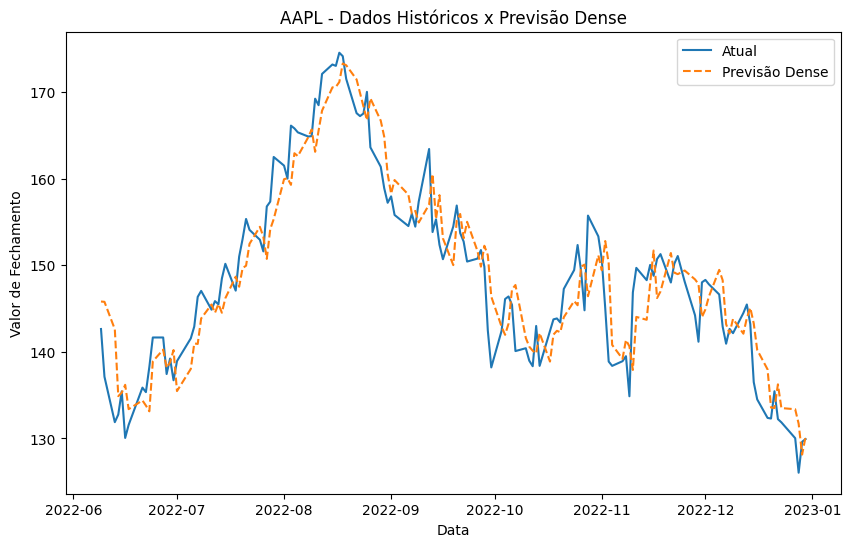

In [43]:
# desnormalizando os dados
y_pred_descaled = scaler.inverse_transform(y_pred)
y_test_descaled = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_descaled, y_pred_descaled))
print(f" RMSE: {rmse:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(test_data.index[sequence_length:], test_data.iloc[sequence_length:], label='Atual')
plt.plot(test_data.index[sequence_length:], y_pred_descaled, label='Previsão Dense', linestyle='--')
plt.title(f'{ticker} - Dados Históricos x Previsão Dense')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

## LSTM

In [44]:
def create_lstm(sequence_length):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

model = create_lstm(sequence_length)
callbacks = [
    ModelCheckpoint("best_lstm_model.keras", save_best_only=True)
]

history = model.fit(X_train, y_train, 
                         epochs=10, 
                         validation_data=(X_val, y_val), 
                         callbacks=callbacks)

model = keras.models.load_model("best_lstm_model.keras")
y_pred = model.predict(X_test)

Epoch 1/10


/home/lucas/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.2646 - val_loss: 0.4307
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1055 - val_loss: 0.0134
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - val_loss: 0.0030
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.0083
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 0.0069
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 0.0056
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 RMSE: 5.67


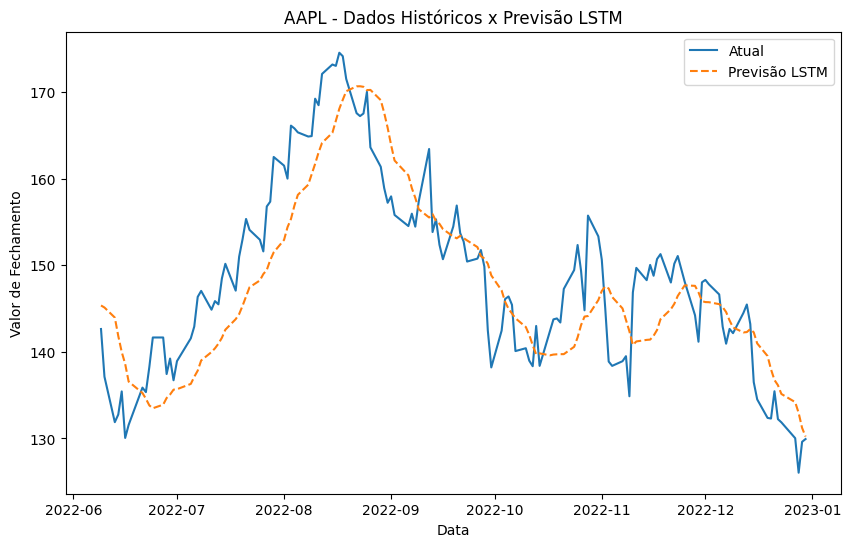

In [45]:
y_pred_descaled = scaler.inverse_transform(y_pred)
y_test_descaled = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_descaled, y_pred_descaled))
print(f" RMSE: {rmse:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(test_data.index[sequence_length:], test_data.iloc[sequence_length:], label='Atual')
plt.plot(test_data.index[sequence_length:], y_pred_descaled, label='Previsão LSTM', linestyle='--')
plt.title(f'{ticker} - Dados Históricos x Previsão LSTM')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

O Naive, agindo como uma média móvel simples e desconsiderando fatores externos na previsão, apresentou um desempenho superior à Rede Densa e à LSTM, possivelmente devido à sua capacidade de capturar a tendência geral dos dados, especialmente quando estes são estocásticos